# Part a): Write your own Stochastic Gradient Descent code, first step
In order to get started, we will now replace in our standard ordinary least squares (OLS) and Ridge regression codes (from project 1) the matrix inversion algorithm with our own gradient descent (GD) and SGD codes. You can use the Franke function or the terrain data from project 1. However, we recommend using a simpler function like a higher-order one-dimensional polynomials. You can obviously test your final codes against for example the Franke function.

The exercise set for week 41 should help in solving this part of the project.

You should include in your analysis of the GD and SGD codes the following elements

### 0. Imports and Setup

In [1]:
from pathlib import Path
project_root_dir = Path.cwd().parent
fig_dir = project_root_dir / 'figs'
from wand.image import Image


import matplotlib.pyplot as plt
from utils import optimal_parameters, plot_mse_contour, FrankeFunction, parameter_print_plot, grid_search
plt.rcParams.update({'text.usetex': True, 'font.size': 18, 'font.family': 'serif', 'font.serif': 'Computer Modern Sans Serif', 'font.weight': 100, 'mathtext.fontset': 'cm', 'xtick.labelsize': 16, 'ytick.labelsize': 16})
import numpy as np
from RegressionModel import RegressionModel
from tqdm import tqdm
seed = 42
np.random.seed(seed)

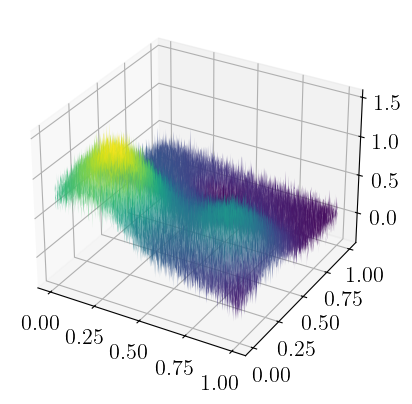

In [2]:
N  = 1000
x = np.arange(0, 1, 1/N).reshape(-1, 1)
y = np.arange(0, 1, 1/N).reshape(-1, 1)
X, Y = np.meshgrid(x, y)

noise = 0.1
z = FrankeFunction(X, Y, noise, seed).reshape(-1, 1)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, z.reshape(N, N), cmap='viridis')
plt.show()

In [3]:
degree = 4
test_size = 0.2
model = RegressionModel(x, y, degree, test_size, seed=seed)

### 1. A plain gradient descent with a fixed learning rate (you will need to tune it) using the analytical expression for the gradient.

Minimum MSE:  6.751e-03
Optimal learning rate:  2.456e-01


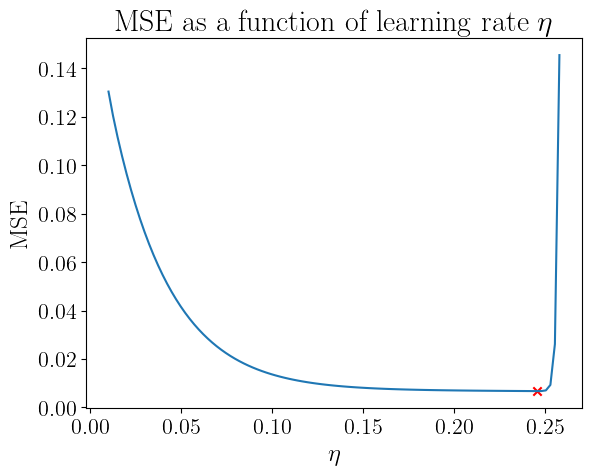

In [4]:
MSE_array_plain = []
param2_array = np.linspace(0.01, 0.258, 101)
for η in param2_array:
    MSE, R2 = model.gradient_descent(50, eta=η)
    MSE_array_plain.append(MSE)
print(f'Minimum MSE: {min(MSE_array_plain): .3e}')
print(f'Optimal learning rate: {param2_array[np.argmin(MSE_array_plain)]: .3e}')

plt.plot(param2_array, MSE_array_plain)
plt.scatter(param2_array[np.argmin(MSE_array_plain)], min(MSE_array_plain), color='red', label='Minimum MSE', marker='x')
plt.xlabel(r'$\eta$')
plt.ylabel('MSE')
plt.title(r'MSE as a function of learning rate $\eta$')
plt.savefig(fig_dir / 'MSE_eta_plain.pdf')
plt.show()

#### Comment
- When increasing the learning rate, we see a decrease in the MSE. 
- It stabilizes right before  0.25, and increases sharply thereafter.  

### 2. Add momentum to the plain GD code and compare convergence with a fixed learning rate (you may need to tune the learning rate). Keep using the analytical expression for the gradient.


#### Parameter Overview

In [5]:
n = 50

γ_plain = np.linspace(0.01, .99, n)
η_plain= np.linspace(0.01, .99, n)
MSE_plain, R2_plain = grid_search(η_plain, γ_plain, ('eta', 'gamma'), 'Momentum', model)

100%|██████████| 50/50 [00:22<00:00,  2.24it/s]


Minimum MSE:        2.931e-05
Optimal η for MSE:  4.300e-01
Optimal γ for MSE:  9.100e-01

Maximum R2:          100.00%
Optimal η for R2:  4.300e-01
Optimal γ for R2:  9.100e-01


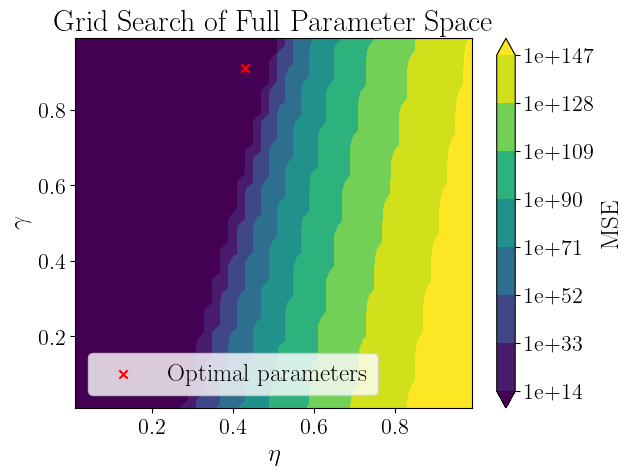

In [6]:
fig = parameter_print_plot(MSE_plain, R2_plain, η_plain, γ_plain, r'$\eta$', r'$\gamma$', scatter=True, log=True)
plt.title(r'Grid Search of Full Parameter Space')
fig.savefig(fig_dir / 'a_2_parameter_overview.pdf') 

In [7]:
γ_plain = np.linspace(0.875, 0.925, n)
η_plain= np.linspace(0.375, 0.425, n)
MSE_plain_zoom, R2_plain_zoom = grid_search(η_plain, γ_plain, ('eta', 'gamma'), 'Momentum', model)

100%|██████████| 50/50 [00:23<00:00,  2.17it/s]


Minimum MSE:        1.946e-05
Optimal η for MSE:  4.066e-01
Optimal γ for MSE:  9.066e-01

Maximum R2:          100.00%
Optimal η for R2:  4.066e-01
Optimal γ for R2:  9.066e-01


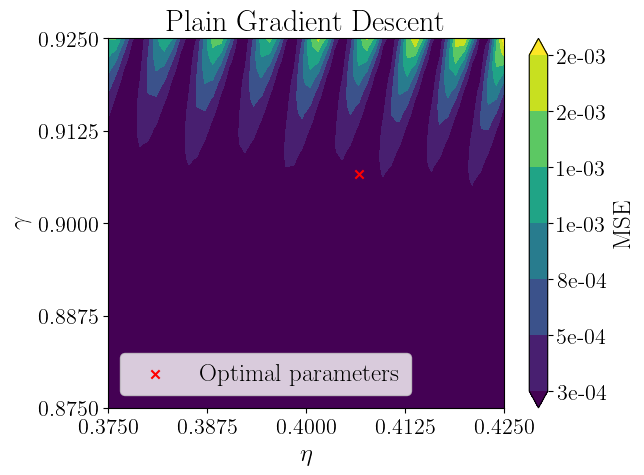

In [8]:
fig = parameter_print_plot(MSE_plain_zoom, R2_plain_zoom, η_plain, γ_plain, r'$\eta$', r'$\gamma$', scatter=True, log=False, n_ticks=5)
plt.title(r'Plain Gradient Descent')
plt.legend(loc='lower left')
fig.savefig(fig_dir / 'GD_eta_gamma.pdf')

#### Tuning both the learning rate and the momentum parameter

##### Tuned parameters

#### Comment
- By trial and error, we closed in on the optimal parameters.
- Minimum MSE: 1.947e-03
    - Optimal η for MSE:  4.173e-01
    - Optimal γ for MSE:  9.066e-01
- Maximum R2:  100.00%
    - Optimal η for R2:  4.173e-01
    - Optimal γ for R2:  9.066e-01
- With $γ > 0.90$, we see long "hairs" of regions with higher MSE. This could suggest it would be wise to stay a bit further left of the optimal γ (0.875 to 0.90), to avoid these regions. Given a slightly different starting point, we could find our optimal parameters to suddenly be in this region.   
- The optimal $η$-values was not that important. 

 ### 3. Repeat these steps for stochastic gradient descent with mini batches and a given number of epochs. Use a tunable learning rate as discussed in the lectures from weeks 39 and 40. Discuss the results as functions of the various parameters (size of batches, number of epochs etc). Use the analytical gradient.

#### 3.a Fixed learning rate

In [9]:
n = 50
n_iterations = 100
dx = N/100
batch_stochastic = np.arange(5, 40 + dx, dx, dtype=int)
η_stochastic = np.linspace(0.01, 0.2, n)
MSE_stochastic, R2_stochastic = grid_search(batch_stochastic, η_stochastic, ('M', 'eta'), 'Momentum', model, stochastic=True)

100%|██████████| 50/50 [00:14<00:00,  3.36it/s]


Minimum MSE:        1.594e-05
Optimal Batch Size for MSE:  5.000e+00
Optimal η for MSE:  2.000e-01

Maximum R2:          100.00%
Optimal Batch Size for R2:  5.000e+00
Optimal η for R2:  2.000e-01


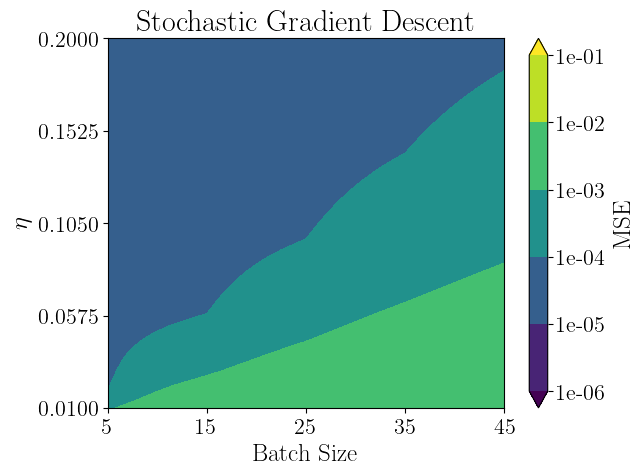

In [10]:
fig = parameter_print_plot(MSE_stochastic, R2_stochastic, batch_stochastic, η_stochastic, x_label='Batch Size', y_label=r'$\eta$', scatter=False, log=True, n_ticks=5)
plt.title('Stochastic Gradient Descent')
fig.savefig(fig_dir / 'SGD_batch_eta_.pdf')

#### 3.b Tuning the learning rate

In [11]:
n = 50
n_iterations = 100
dx = N/100
η = 0.2
batch_array = np.arange(15, 40 + dx, dx, dtype=int)
γ_array = np.linspace(0.5, 0.85, n)

MSE_stochastic_momentum, R2_stochastic_momentum = grid_search(batch_array, γ_array, ('M', 'gamma'), 'Momentum', model, stochastic=True, eta=η)

100%|██████████| 50/50 [00:04<00:00, 10.13it/s]


Minimum MSE:        9.625e-06
Optimal Batch Size for MSE:  1.500e+01
Optimal γ for MSE:  8.000e-01

Maximum R2:          100.00%
Optimal Batch Size for R2:  1.500e+01
Optimal γ for R2:  8.000e-01


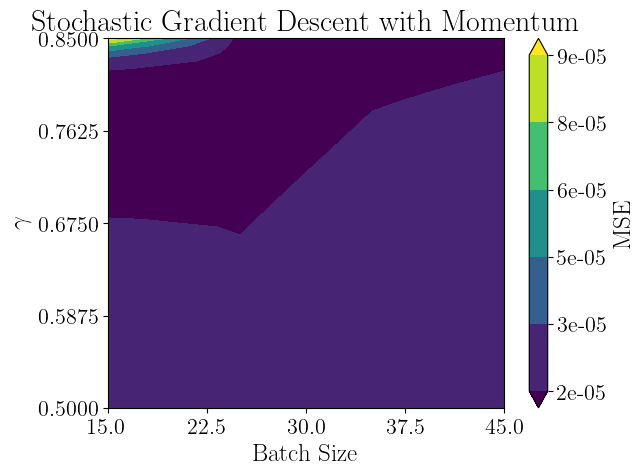

In [12]:
fig = parameter_print_plot(MSE_stochastic_momentum, R2_stochastic_momentum, batch_array, γ_array, x_label='Batch Size', y_label=r'$\gamma$', scatter=False, log=False, n_ticks=5)
plt.title('Stochastic Gradient Descent with Momentum')
plt.savefig(fig_dir / 'SGD_batch_gamma.pdf')

### 4. Implement the Adagrad method in order to tune the learning rate. Do this with and without momentum for plain gradient descent and SGD.

#### 4.a Gradient Descent

In [13]:
n = 101
η_Ada = np.linspace(0.1, 0.8, n)
MSE_Ada, R2_Ada = grid_search(η_Ada, η_Ada, ('eta', 'eta'), 'AdaGrad', model)

100%|██████████| 101/101 [01:34<00:00,  1.06it/s]


In [14]:
n = 50
η_Ada_mom = np.linspace(0.2, 0.6, n)
γ_Ada_mom = np.linspace(0.85, 0.9, n)
method = 'AdagradMomentum'
MSE_Ada_mom, R2_Ada_mom = grid_search(η_Ada_mom, γ_Ada_mom, ('eta', 'gamma'), method=method, model=model)

100%|██████████| 50/50 [00:30<00:00,  1.65it/s]


Minimum MSE:        3.047e-03
Optimal η for MSE:  3.959e-01
Optimal γ for MSE:  9.000e-01

Maximum R2:           99.69%
Optimal η for R2:  3.959e-01
Optimal γ for R2:  9.000e-01


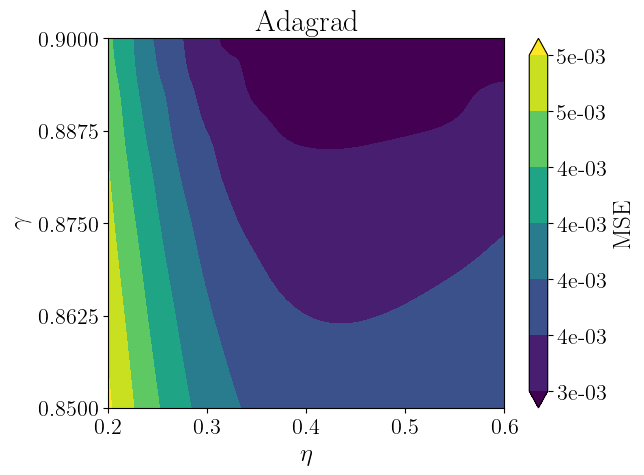

In [15]:
fig = parameter_print_plot(MSE_Ada_mom, R2_Ada_mom, η_Ada_mom, γ_Ada_mom, r'$\eta$', r'$\gamma$', scatter=False, log=False, n_ticks=5)
plt.title('Adagrad')
plt.savefig(fig_dir / 'AdagradMomentum_eta_gamma.pdf')

In [16]:
n = 50
γ_Ada_mom_stochastic = np.linspace(0.85, 0.9, n)
η_Ada_mom_stochastic = np.linspace(0.2, 0.6, n)
method = 'AdagradMomentum'
MSE_Ada_mom_stochastic, R2_Ada_mom_stochastic = grid_search(η_Ada_mom_stochastic, γ_Ada_mom_stochastic, ('eta', 'gamma'), method, model, stochastic=True, M=10)

100%|██████████| 50/50 [05:26<00:00,  6.54s/it]


Minimum MSE:        1.236e-05
Optimal η for MSE:  6.000e-01
Optimal γ for MSE:  8.980e-01

Maximum R2:          100.00%
Optimal η for R2:  6.000e-01
Optimal γ for R2:  8.980e-01


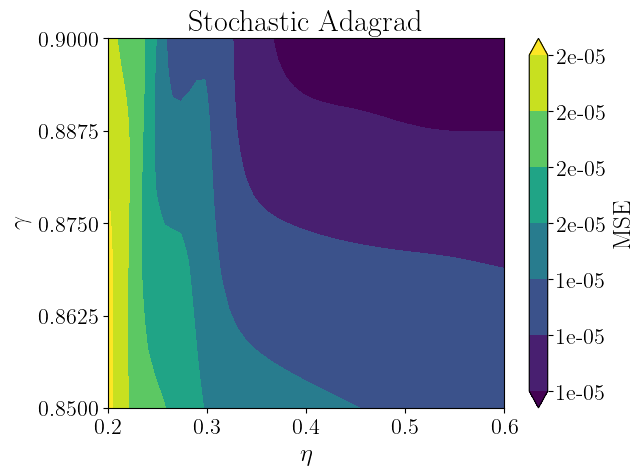

In [17]:
fig = parameter_print_plot(MSE_Ada_mom_stochastic, R2_Ada_mom_stochastic, η_Ada_mom_stochastic, γ_Ada_mom_stochastic, r'$\eta$', r'$\gamma$', scatter=False, log=False, n_ticks=5)
plt.title('Stochastic Adagrad')
fig.savefig(fig_dir / 'AdagradMomentum_stochastic_eta_gamma.pdf')

### 5. Add RMSprop and Adam to your library of methods for tuning the learning rate.

#### 5.a RMSprop

In [18]:
n = 50
n_iterations = 100
η_RMS = np.linspace(0.01, 0.15, n)
ρ_RMS = np.linspace(0.01, 0.9, n)
method = 'RMS_Prop'
MSE_RMS, R2_RMS = grid_search(η_RMS, ρ_RMS, ('eta', 'rho_1'), method=method, model=model)

100%|██████████| 50/50 [00:22<00:00,  2.23it/s]


Minimum MSE:        5.371e-03
Optimal η for MSE:  2.714e-02
Optimal ρ for MSE:  9.000e-01

Maximum R2:           99.45%
Optimal η for R2:  2.714e-02
Optimal ρ for R2:  9.000e-01


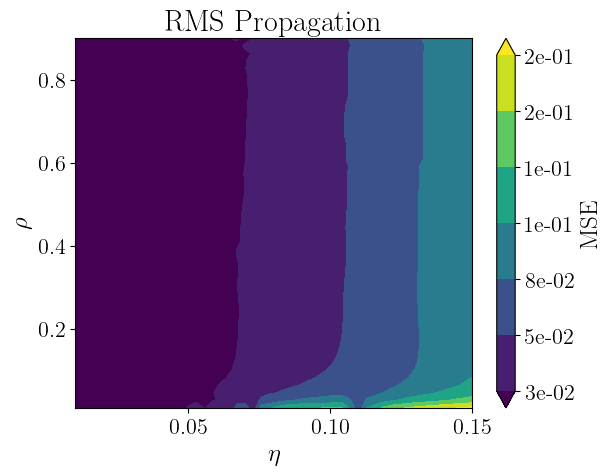

In [19]:
fig = parameter_print_plot(MSE_RMS, R2_RMS, η_RMS, ρ_RMS, r"$\eta$", r"$\rho$", scatter=False, log=False)
plt.title('RMS Propagation')
fig.savefig(fig_dir / 'RMS_Prop_eta_rho.pdf')

In [20]:
n = 50
n_iterations = 100
η_RMS_stochastic = np.linspace(0.01, 0.15, n)
ρ_RMS_stochastic = np.linspace(0.01, 0.9, n)
MSE_RMS_stochastic, R2_RMS_stochastic = grid_search(η_RMS_stochastic, ρ_RMS_stochastic, ('eta', 'rho_1'), method='RMS_Prop', model=model, stochastic=True, M=10)

100%|██████████| 50/50 [04:19<00:00,  5.18s/it]


Minimum MSE:        3.847e-04
Optimal η for MSE:  1.000e-02
Optimal ρ for MSE:  1.371e-01

Maximum R2:           99.96%
Optimal η for R2:  1.000e-02
Optimal ρ for R2:  1.371e-01


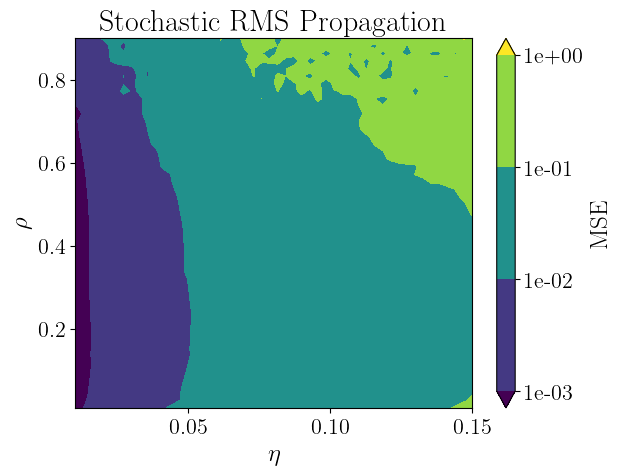

In [21]:
fig = parameter_print_plot(MSE_RMS_stochastic, R2_RMS_stochastic, η_RMS_stochastic, ρ_RMS_stochastic, r"$\eta$", r"$\rho$")
plt.title('Stochastic RMS Propagation')
fig.savefig(fig_dir / 'RMS_Prop_stochastic_eta_rho.pdf')

In [22]:
ρ = 0.2
n = 101
η_RMS_zoom = np.linspace(0.001, 0.05, n)
MSE_RMS_zoom = []
MSE_RMS_zoom_stochastic = []
R2_RMS_zoom = []
R2_RMS_zoom_stochastic = []
for η in tqdm(η_RMS_zoom):
    MSE, R2 = model.gradient_descent(n_iterations, eta=η, tuning_method='RMS_Prop', rho_1=ρ)
    MSE_RMS_zoom.append(MSE)
    R2_RMS_zoom.append(R2)
    MSE_stochastic, R2_stochastic = model.stochastic_gradient_descent(n_iterations, eta=η, tuning_method='RMS_Prop', rho_1=ρ, M=20)
    MSE_RMS_zoom_stochastic.append(MSE_stochastic)
    R2_RMS_zoom_stochastic.append(R2_stochastic)

100%|██████████| 101/101 [00:06<00:00, 15.91it/s]


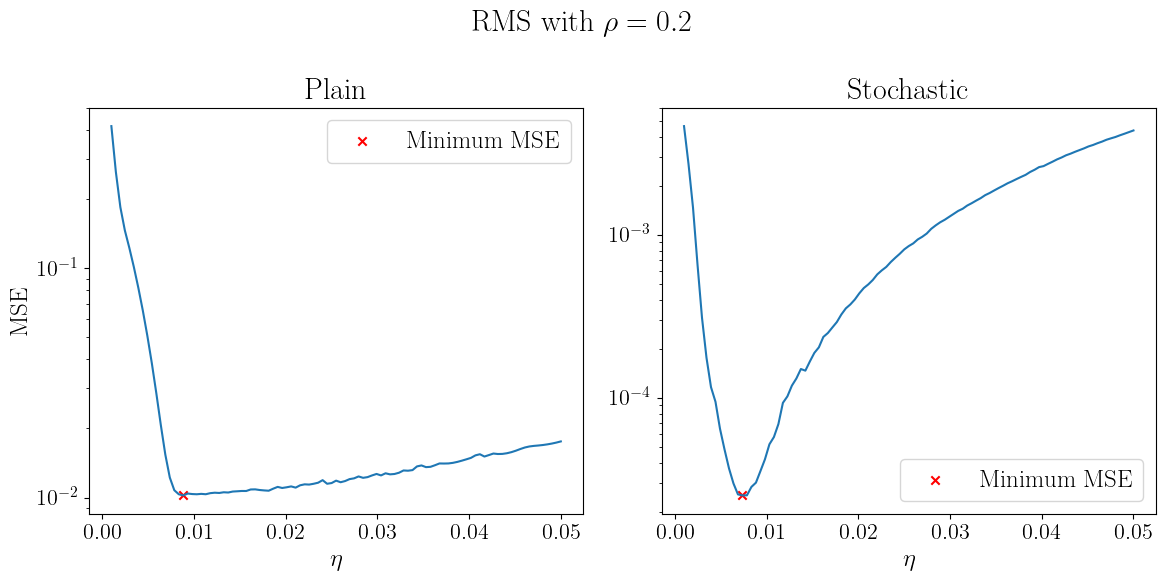

In [23]:
plt.subplot(121)
plt.semilogy(η_RMS_zoom, MSE_RMS_zoom)
plt.scatter(η_RMS_zoom[np.argmin(MSE_RMS_zoom)], min(MSE_RMS_zoom), color='red', label='Minimum MSE', marker='x')
plt.xlabel(r'$\eta$')
plt.ylabel('MSE')
plt.title(r'Plain')
plt.legend()

plt.subplot(122)
plt.semilogy(η_RMS_zoom, MSE_RMS_zoom_stochastic)
plt.scatter(η_RMS_zoom[np.argmin(MSE_RMS_zoom_stochastic)], min(MSE_RMS_zoom_stochastic), color='red', label='Minimum MSE', marker='x')
plt.xlabel(r'$\eta$')
plt.title(r'Stochastic')
plt.legend()

plt.gcf().set_size_inches(12, 6)
plt.suptitle(r'RMS with $\rho = 0.2$')
plt.tight_layout()


plt.savefig(fig_dir / 'RMS_Prop_zoom.pdf')

#### 5.b Adam

In [24]:
n_iterations = 100
n = 50
η_Adam = np.linspace(0.01, 0.15, n)
ρ_Adam = np.linspace(0.01, 0.9, n)
MSE_Adam, R2_Adam = grid_search(η_Adam, ρ_Adam, ('eta', ('rho_1', 'rho_2')), method='Adam', model=model)

100%|██████████| 50/50 [00:28<00:00,  1.78it/s]


Minimum MSE:        4.627e-04
Optimal η for MSE:  1.386e-01
Optimal $\rho_1, \rho_2$ for MSE:  8.818e-01

Maximum R2:           99.95%
Optimal η for R2:  1.386e-01
Optimal $\rho_1, \rho_2$ for R2:  8.818e-01


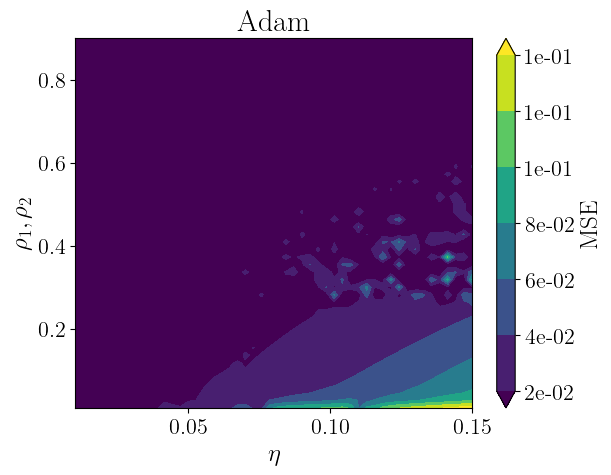

In [25]:
fig = parameter_print_plot(MSE_Adam, R2_Adam, η_Adam, ρ_Adam, r"$\eta$", r"$\rho_1, \rho_2$", log=False)
plt.title('Adam')
fig.savefig(fig_dir / 'Adam_eta_rho.pdf')

In [26]:
n_iterations = 100
n = 50
η_Adam_stochastic = np.linspace(0.01, 0.1, n)
ρ_Adam_stochastic = np.linspace(0.2, 0.9, n)
MSE_Adam_stochastic, R2_Adam_stochastic = grid_search(η_Adam_stochastic, ρ_Adam_stochastic, ('eta', ('rho_1', 'rho_2')), method='Adam', model=model, stochastic=True, M=20)

100%|██████████| 50/50 [02:54<00:00,  3.48s/it]


Minimum MSE:        9.172e-06
Optimal η for MSE:  6.143e-02
Optimal ρ for MSE:  7.571e-01

Maximum R2:          100.00%
Optimal η for R2:  6.143e-02
Optimal ρ for R2:  7.571e-01


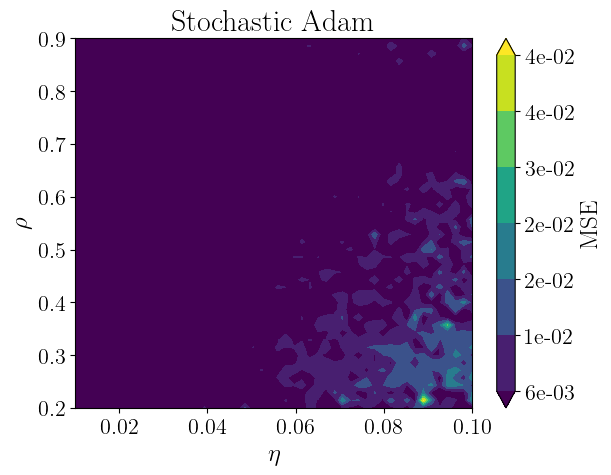

In [27]:
fig = parameter_print_plot(MSE_Adam_stochastic, R2_Adam_stochastic, η_Adam_stochastic, ρ_Adam_stochastic, r"$\eta$", r"$\rho$", log=False)
plt.title('Stochastic Adam')
fig.savefig(fig_dir / 'Adam_stochastic_eta_rho.pdf')

In [28]:
ρ = 0.75
n = 101
η_Adam_zoom = np.linspace(0.01, 0.1, n)
MSE_Adam_zoom = []
MSE_Adam_zoom_stochastic = []
R2_Adam_zoom = []
R2_Adam_zoom_stochastic = []
for η in tqdm(η_Adam_zoom):
    MSE, R2 = model.gradient_descent(n_iterations, eta=η, tuning_method='Adam', rho_1=ρ, rho_2=ρ)
    MSE_Adam_zoom.append(MSE)
    R2_Adam_zoom.append(R2)
    MSE_stochastic, R2_stochastic = model.stochastic_gradient_descent(n_iterations, eta=η, tuning_method='Adam', rho_1=ρ, rho_2=ρ, M=20)
    MSE_Adam_zoom_stochastic.append(MSE_stochastic)
    R2_Adam_zoom_stochastic.append(R2_stochastic)

100%|██████████| 101/101 [00:07<00:00, 13.06it/s]


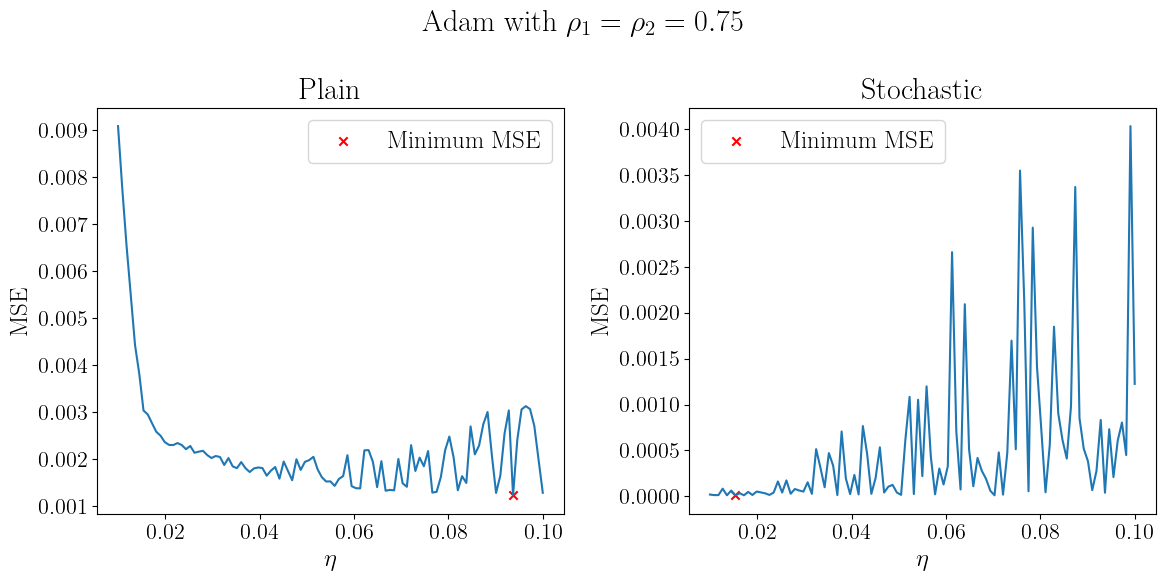

In [29]:
plt.subplot(121)
plt.plot(η_Adam_zoom, MSE_Adam_zoom)
plt.scatter(η_Adam_zoom[np.argmin(MSE_Adam_zoom)], min(MSE_Adam_zoom), color='red', label='Minimum MSE', marker='x')
plt.xlabel(r'$\eta$')
plt.ylabel('MSE')
plt.title(r'Plain')
plt.legend()

plt.subplot(122)
plt.plot(η_Adam_zoom, MSE_Adam_zoom_stochastic)
plt.scatter(η_Adam_zoom[np.argmin(MSE_Adam_zoom_stochastic)], min(MSE_Adam_zoom_stochastic), color='red', label='Minimum MSE', marker='x')
plt.xlabel(r'$\eta$')
plt.ylabel('MSE')
plt.title(r'Stochastic')
plt.legend()

plt.gcf().set_size_inches(12, 6)
plt.suptitle(r'Adam with $\rho_1 = \rho_2 = 0.75$')
plt.tight_layout()

plt.savefig(fig_dir / 'Adam_zoom.pdf')